In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels import api as sm
from sklearn.metrics import cohen_kappa_score, ConfusionMatrixDisplay, confusion_matrix, classification_report

from time import process_time

# Preprocessing

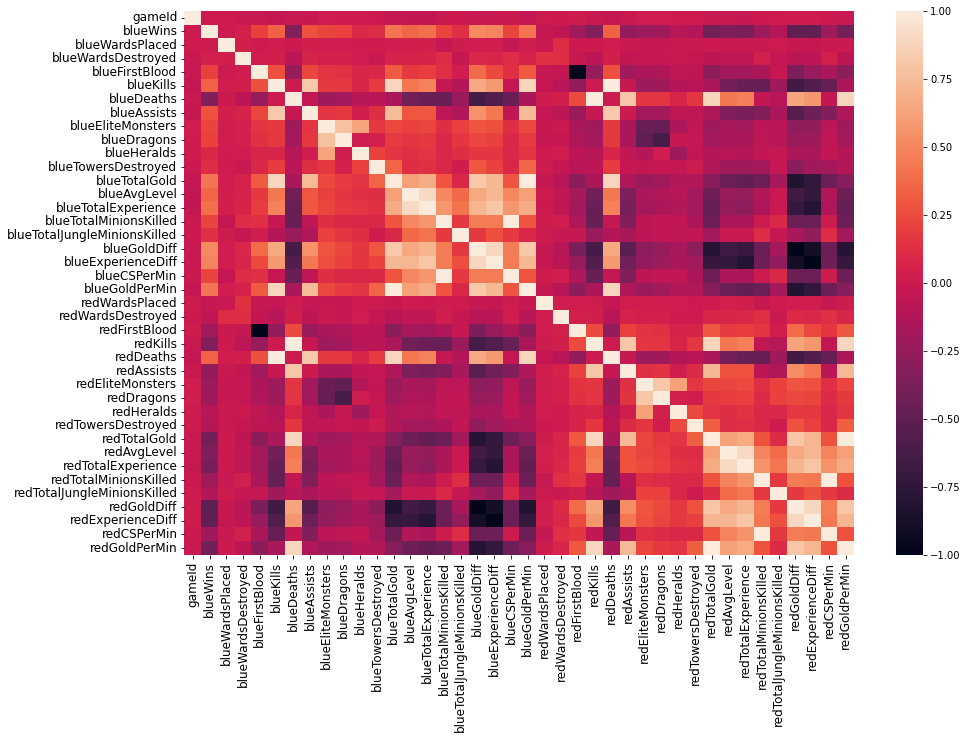

In [3]:
data = pd.read_csv('high_diamond_ranked_10min.csv')
x = data.drop(['gameId', 'blueWins'], axis=1) # skip gameId and blueWins
y = data['blueWins'] # blueWins

corr_coeffs = data.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_coeffs, vmin=-1.0, vmax=1.0)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12)
fig.set_facecolor('white')

^ remove redDeaths + blueDeaths => they're highly correlated with red/blueKills (obviously)

CSPerMin, and GoldPerMin could be removed as they are related to the TotalMinions etc, and TotalGold. AND we're predicting at 10 min, not per minute. (probably?)

^ thus PCA

### Clean + Split

In [4]:
# x = x.drop(['redDeaths', 'blueDeaths', 'redCSPerMin', 'blueCSPerMin', 'redGoldPerMin', 'blueGoldPerMin'], axis=1)

In [6]:
cutoff_train = round(x.shape[0] * 0.5)
cutoff_val = round(x.shape[0] * 0.75)
print(cutoff_train)
print(cutoff_val)

train_X = x[:cutoff_train].to_numpy()
train_y = y[:cutoff_train].to_numpy()

val_X = x[cutoff_train:cutoff_val].to_numpy()
val_y = y[cutoff_train:cutoff_val].to_numpy()

test_X = x[cutoff_val:].to_numpy() # the rest
test_y = y[cutoff_val:].to_numpy()

print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

print(test_y.shape)

4940
7409
(4940, 38)
(2469, 38)
(2470, 38)
(2470,)


### Standardise

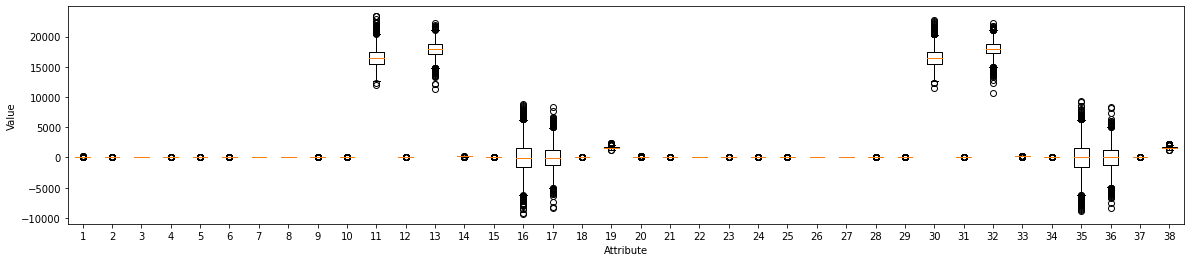

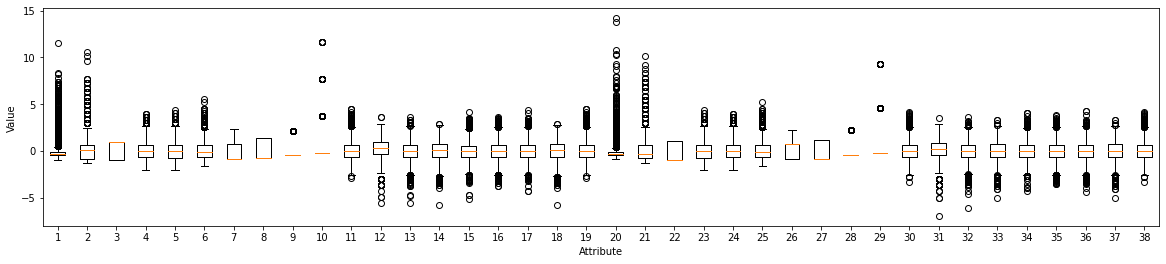

In [7]:
fig, ax = plt.subplots(figsize=(20,4))
plt.boxplot(train_X)
plt.xlabel("Attribute")
plt.ylabel("Value")
fig.set_facecolor('white')

mu = np.mean(train_X, axis=0)
sigma = np.std(train_X, axis=0)
std = (train_X - mu) / sigma
fig, ax = plt.subplots(figsize=(20,4))
plt.boxplot(std)
plt.xlabel("Attribute")
plt.ylabel("Value")
fig.set_facecolor('white')

^ small features rescaled, not out-competed by others. So use standardisation

In [8]:
train_X = (train_X - mu) / sigma
val_X = (val_X - mu) / sigma
test_X = (test_X - mu) / sigma

(array([2502.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2438.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

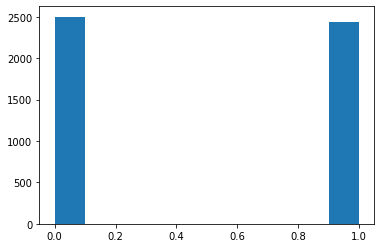

In [9]:
plt.hist(train_y)

# Helper functions

In [10]:
# helper function adapted from lecture examples

# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - get precision, recall, f1 for test data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, x_train, y_train, x_test, y_test):
    fig = plt.figure(figsize=[10, 5])
    fig.set_facecolor('white')

    ax = fig.add_subplot(1, 2, 1)
    pred = model.predict(x_train);
    cm = confusion_matrix(y_train, pred)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)
    ax.set_title('Training Set Performance: %1.3f' % (sum(pred == y_train)/len(y_train)));
    
    ax = fig.add_subplot(1, 2, 2)
    
    t1 = process_time() 
    pred = model.predict(x_test);
    t2 = process_time()
    print('Test prediction time: ', t2-t1)

    cm = confusion_matrix(y_test, pred)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)    
    ax.set_title('Testing Set Performance: %1.3f' % (sum(pred == y_test)/len(y_test)));

    print(classification_report(y_test, pred))

    print("Cohen Kappa score: ")
    print(cohen_kappa_score(y_test, pred))

## ! Maybe use Cohen's Kappa?

How to interpret: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900052/  (Cohen’s kappa heading)

Since its only binary output (1 or 0 for win) - then worst case (random) accuracy would be a score of 50%. Cohen Kappa rectifies it by comparing "the empirical probability of agreement on the label assigned to any sample (the observed agreement ratio), and the expected agreement when both annotators assign labels randomly" - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html

why: https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers - "Instead, measures such as the phi coefficient, Matthews correlation coefficient, informedness or Cohen's kappa may be preferable to assess the performance of a binary classifier."[17][18]

# Dimension Reduction - PCA

In [47]:
from sklearn import decomposition

t1 = process_time() 

pca = decomposition.PCA()
pca.fit(train_X)
transformed = pca.transform(train_X)
transformed_val = pca.transform(val_X)
transformed_test = pca.transform(test_X)

## up to dim (exclusive) where variance explained 95% 
cumulative_sum = np.cumsum(pca.explained_variance_ratio_, axis=0)
print(cumulative_sum)
top95 = np.where(cumulative_sum > 0.95)[0][0]

transformed_train_95 = transformed[:, 0:top95]
transformed_val_95 = transformed_val[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

t2 = process_time()
print('Elapsed time: ', t2-t1)

[0.32723502 0.44855776 0.5190281  0.58363379 0.6326905  0.67216094
 0.7079998  0.74249886 0.77561802 0.80471296 0.83242154 0.85919637
 0.88273292 0.90429368 0.92502616 0.94516941 0.95831356 0.96899105
 0.9794673  0.98584862 0.99075624 0.99407538 0.99636375 0.99847477
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
Elapsed time:  0.015625


In [48]:
print(transformed_train_95.shape)
print(transformed_val_95.shape)
print(transformed_test_95.shape)

(4940, 16)
(2469, 16)
(2470, 16)


# Ensemble Classifier

## Random Forest 🌲🌲🌲

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [18]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
max_features = ['sqrt']
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

# random grid
param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf,
    'bootstrap' : bootstrap
}
print(param_grid)

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['sqrt'], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [19]:
rf = RandomForestClassifier()

In [20]:
from sklearn.model_selection import GridSearchCV
rf_grid = GridSearchCV(estimator= rf, param_grid= param_grid, cv = 3)

In [21]:
rf_grid.fit(train_X, train_y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157,
                                          178, 200]})

In [22]:
rf_grid.best_params_

{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 136}

In [26]:
print(f'Training: {rf_grid.score(train_X, train_y):.3f}')
print(f'Training: {rf_grid.score(test_X, test_y):.3f}')




Training: 0.988
Training: 0.722


# SVM classfier

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1237
           1       0.72      0.71      0.72      1233

    accuracy                           0.72      2470
   macro avg       0.72      0.72      0.72      2470
weighted avg       0.72      0.72      0.72      2470

Cohen Kappa score: 
0.43561790953180535


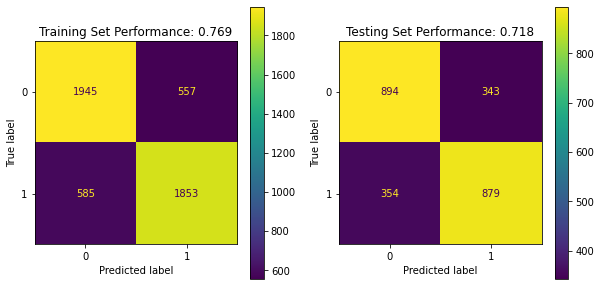

In [21]:
from sklearn.svm import SVC

# test default svc
svm = SVC()
svm.fit(train_X, train_y)
eval_model(svm, train_X, train_y, test_X, test_y) 

test with param grid using C and other parameters (grid search)

In [30]:
from sklearn.model_selection import GridSearchCV

###
# BRUH this takes me 24 mins to run on a 5600x, maybe cuz of data otherwise may need to narrow down parameters
###

###
# Maybe we should do PCA, they did suggest doing that in the feedback
###

param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3, 4, 5, 6], 'kernel': ['poly']},
 ]
svm = SVC()
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(train_X, train_y)
grid_search.cv_results_

NameError: name 'SVC' is not defined

In [ ]:
best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
svm = SVC().set_params(**params)
svm.fit(train_X, train_y)
eval_model(svm, train_X, train_y, test_X, test_y)

! i've added pca, use that

# DNN (dense layers)

# TabNet

https://www.kaggle.com/code/carlmcbrideellis/tabnet-simple-binary-classification-example/notebook

https://github.com/dreamquark-ai/tabnet

### Helper

In [14]:
def model_history(history, keys):
    fig = plt.figure(figsize=[14, 5])
    fig.set_facecolor('white')

    ax = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    for key in keys:
        if ('loss' in key):
            ax.plot(history.history[key], label=key)
        else:
            ax2.plot(history.history[key], label=key)
    
    ax.legend()
    ax.set_title('Training Loss')

    ax2.legend()
    ax2.set_title('Training Performance')

https://paperswithcode.com/method/tabnet

pip install pytorch-tabnet

https://dreamquark-ai.github.io/tabnet/generated_docs/pytorch_tabnet.html#module-pytorch_tabnet.tab_model

In [67]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch

import itertools as it

## Unsupervised pretraining

In [69]:
t1 = process_time()

unsupervised_model = TabNetPretrainer(
    verbose=0,
    seed=42,
    mask_type='entmax',
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.02),
    scheduler_params={"step_size": 10,
                    "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR
)

unsupervised_model.fit(
    X_train=transformed_train_95,
    batch_size=512, # 10% of 5000
    virtual_batch_size=64,
    eval_set=[transformed_val_95],
    eval_name=['val'],
    max_epochs=200,
    pretraining_ratio=0.5,
)

t2 = process_time()
print('Elapsed time: ', t2-t1)


Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_unsup_loss = 0.87956
Best weights from best epoch are automatically used!
Elapsed time:  140.28125


No handles with labels found to put in legend.


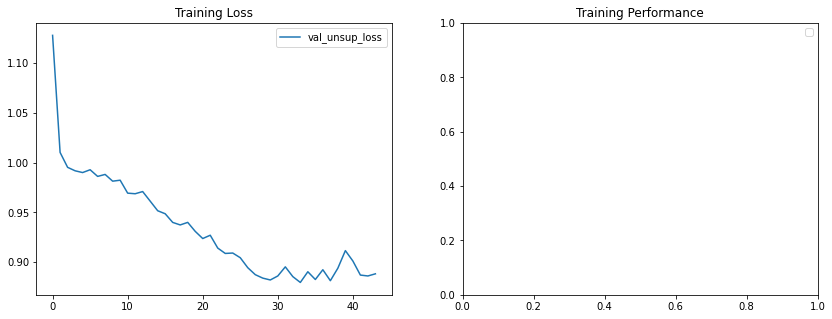

In [70]:
model_history(unsupervised_model.history, ['val_unsup_loss'])

## Supervised training

In [ ]:
# hyperparams = {
#     'N': [8, 16, 24, 32, 64, 128],
#     'Nsteps': [3, 4, 5, 6, 7, 8, 9, 10],
#     'gamma': [1.0, 1.2, 1.5, 2.0],
#     'lambda_sparse': [0, 0.000001, 0.0001, 0.001, 0.01, 0.1],
#     'lr': [0.005, 0.01, 0.02, 0.025],
#     'decay': [0.4, 0.8, 0.9, 0.95],
#     'decay_iter': [0.5, 2, 8, 10, 20],
#     'mB': [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
# }

hyperparams = {
    'N': [8],
    'Nsteps': [3],
    'gamma': [1.0, 1.1, 1.2, 1.5, 2.0],
    'lambda_sparse': [0, 0.000001, 0.0001, 0.001, 0.01, 0.1]
}

search_space = list(it.product(*list(hyperparams.values())))

print(len(search_space))

t1 = process_time()

best_score = 0
best_params = []
for params in search_space:
    tabnet = TabNetClassifier(
        n_a=params[0],
        n_d=params[0],
        n_steps=params[1],
        gamma=params[2],
        lambda_sparse=params[3],
        verbose=0,
        seed=42,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=0.02),
        scheduler_params={"step_size": 10,
                        "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR
    )

    tabnet.fit(transformed_train_95, train_y,
        batch_size=512, # 10% of 5000
        virtual_batch_size=64,
        max_epochs=200,
        eval_set=[(transformed_val_95, val_y)],
        eval_name=['val'],
        eval_metric=['accuracy'],
        from_unsupervised=unsupervised_model
    )

    score = max(tabnet.history.history['val_accuracy'])

    if (score > best_score):
        best_score = score
        best_params = params

In [73]:
t2 = process_time()
print('Elapsed time: ', t2-t1)

print(best_params)
# (8, 3, 2.0, 0.1)
# (8, 3, 1.0, 0.0001) - v2

Elapsed time:  1780.421875
(8, 3, 1.0, 0.0001)


Loading weights from unsupervised pretraining


c:\Users\golde\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_tabnet\abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_accuracy = 0.73228
Best weights from best epoch are automatically used!
Elapsed time:  44.9375
Test prediction time:  0.375
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1237
           1       0.72      0.73      0.73      1233

    accuracy                           0.73      2470
   macro avg       0.73      0.73      0.73      2470
weighted avg       0.73      0.73      0.73      2470

Cohen Kappa score: 
0.451828331616667


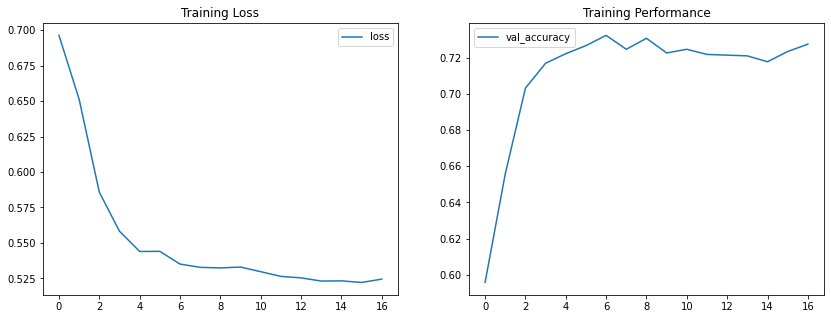

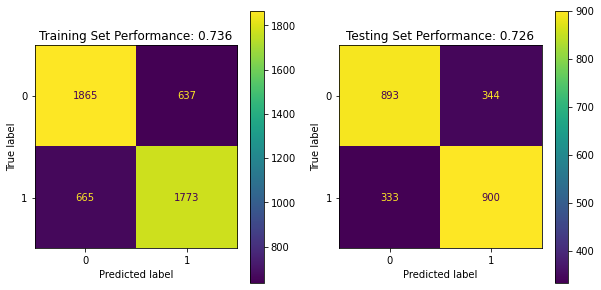

In [76]:
t1 = process_time()

tabnet = TabNetClassifier(
    n_a=best_params[0],
    n_d=best_params[0],
    n_steps=best_params[1],
    gamma=best_params[2],
    lambda_sparse=best_params[3],
    verbose=0,
    seed=42,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.02),
    scheduler_params={"step_size": 10,
                    "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR
)

tabnet.fit(transformed_train_95, train_y,
    batch_size=512, # 10% of 5000
    virtual_batch_size=64,
    max_epochs=200,
    eval_set=[(transformed_val_95, val_y)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    from_unsupervised=unsupervised_model
)

t2 = process_time()
print('Elapsed time: ', t2-t1)

model_history(tabnet.history, ['loss', 'val_accuracy'])
eval_model(tabnet, transformed_train_95, train_y, transformed_test_95, test_y)